# Task 1 - Classification

### Dataset

Let's first set up the dataset. We have to reorganize the files to match PyTorch's DataLoader.

Note: You don't have to run this, the data is already organised.

In [ ]:
import os
import shutil

from others.general import TASK1_LIST
import random


source_dir = 'dataset/easy'
destination_dir = 'dataset/task1'

os.makedirs(destination_dir, exist_ok=True)
os.makedirs(os.path.join(destination_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(destination_dir, 'val'), exist_ok=True)
os.makedirs(os.path.join(destination_dir, 'test'), exist_ok=True)


for filename in os.listdir(source_dir):
    if filename.endswith('.png'):
        parts = filename.split('_')
        word = parts[0].lower()
        if word not in TASK1_LIST: continue

        new_dir = os.path.join(destination_dir, 'train', word)
        os.makedirs(new_dir, exist_ok=True)
        shutil.copy(os.path.join(source_dir, filename), os.path.join(new_dir, f'easy_{parts[1]}'))


source_dir = 'dataset/hard'

for filename in os.listdir(source_dir):
    if filename.endswith('.png'):
        parts = filename.split('_')
        word = parts[0].lower()
        if word not in TASK1_LIST: continue
        
        category = random.choices(population=['train', 'val', 'test'], weights=[0.7, 0.2, 0.1], k=1)[0]
        new_dir = os.path.join(destination_dir, category, word)
        os.makedirs(new_dir, exist_ok=True)

        shutil.copy(os.path.join(source_dir, filename), os.path.join(new_dir, f"hard-{parts[1]}-{parts[2]}-{parts[3]}-{parts[4]}"))


In [2]:
!find /kaggle/input/precog-task1/task1/train | wc -l
!find /kaggle/input/precog-task1/task1/val | wc -l
!find /kaggle/input/precog-task1/task1/test | wc -l

find: /kaggle/input/precog-task1/task1/train: No such file or directory
       0
find: /kaggle/input/precog-task1/task1/val: No such file or directory
       0
find: /kaggle/input/precog-task1/task1/test: No such file or directory
       0


The training dataset has 18047 files, and the validation dataset has 5098 files, and the test set has 2566 files (no overlap)

Let's first set up the hyper-parameters & dataset.

Notes:
- Transforms: Image into a tensor, then normalizes it. The normalization has 2 sequences, one for means and one for standard deviation. Each sequence has a value for each channel of the image (our image is RGB, hence 3 channels). Converting to tensor changes the [0, 255] of each RGB value to [0, 1], and the normalization converts it to [-1, 1].

$$
x_{\text{normalized}} = \frac{x - mean}{std}
$$

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm


# Hyperparameters

NUM_EPOCHS = 100
BATCH_SIZE = 4
LEARNING_RATE = 0.0001
DROPOUT_PROBABILITY = 0.4

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((100, 250)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# task1_directory = '/kaggle/input/precog-task1/task1'
task1_directory = 'dataset/task1'

train_dataset = datasets.ImageFolder(f'{task1_directory}/train', transform=transform)
val_dataset = datasets.ImageFolder(f'{task1_directory}/val', transform=transform)
test_dataset = datasets.ImageFolder(f'{task1_directory}/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

Training: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


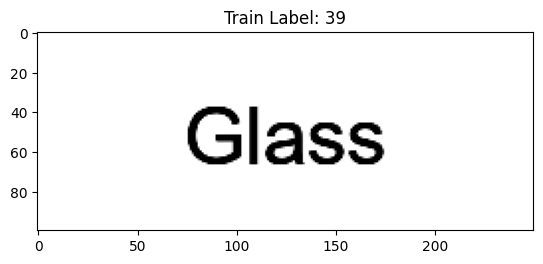

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


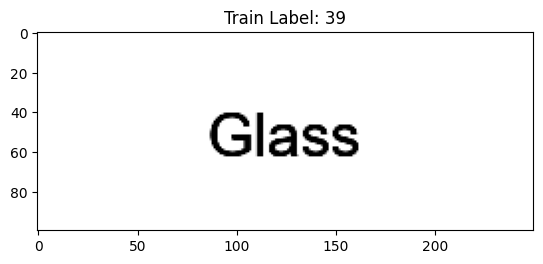

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


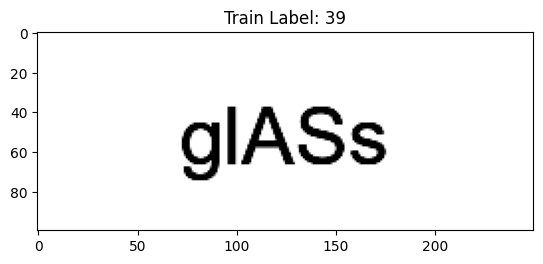

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


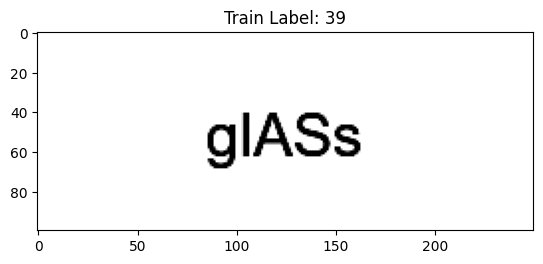

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


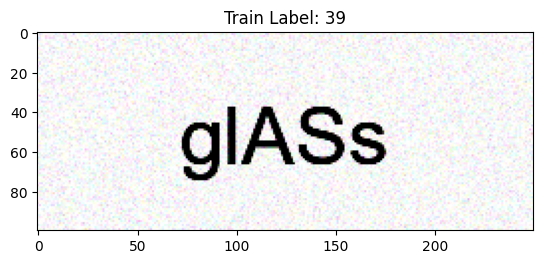

Val: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


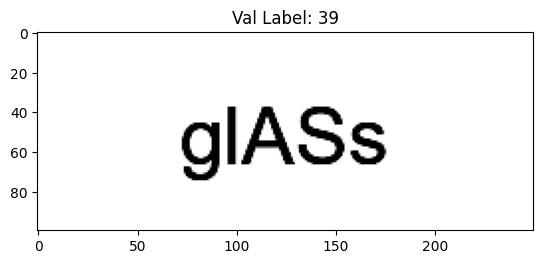

Test: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


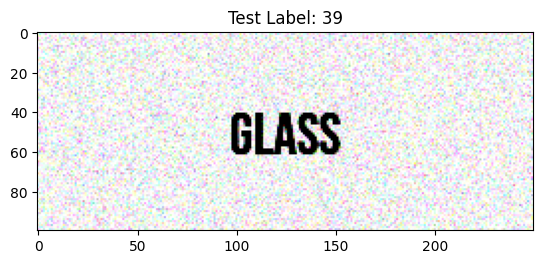

In [5]:
import numpy as np
import matplotlib.pyplot as plt

show_label = 39
time = 5

print("Training: ")

for i in range(len(train_dataset)):
    image, label = train_dataset[i]
    if label == show_label:
        np_image = image.numpy().transpose((1, 2, 0))
        plt.imshow(np_image)
        plt.title(f"Train Label: {label}")
        plt.show()

        time -= 1
        if time == 0: break


print("Val: ")

for i in range(len(val_dataset)):
    image, label = val_dataset[i]
    if label == show_label:
        np_image = image.numpy().transpose((1, 2, 0))
        plt.imshow(np_image)
        plt.title(f"Val Label: {label}")
        plt.show()
        break


print("Test: ")

for i in range(len(test_dataset)):
    image, label = test_dataset[i]
    if label == show_label:
        np_image = image.numpy().transpose((1, 2, 0))
        plt.imshow(np_image)
        plt.title(f"Test Label: {label}")
        plt.show()
        break

Now, let's define the model architecture.

Notes:
- Conv2d: `in_channels` is number of inputs layers (3 for RGB in conv1, or feature maps from prev layer), `out_channels` are the number of feature maps the layer creates
- BatchNorm2d: Normalises activations and stabilizes learning process
- MaxPool2d: Reduces dimensions of image to decrease computational load

In [6]:
class CNN(nn.Module):
    def __init__(self, num_classes=100):
        super(CNN, self).__init__()

        # First convolutional block, takes in (3 x H x W) -> 32 feature maps
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) 

        # Convolutional block 2, takes in 32 feature maps -> 64 feature maps
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolutional block 3, takes in 64 feature maps -> 128 feature maps
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Adaptive pooling layer to reduce the feature map size to (1 x 1)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Dropout to avoid overfitting
        self.dropout = nn.Dropout(p=0.2)

        # Fully connected layer
        self.fc = nn.Linear(128, num_classes)


    def forward(self, x):
        # Each block has a convolutional layer, followed by a batch normalization layer, followed by a ReLU activation layer, then a pooling layer
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        # Reduce the feature map size to (1 x 1)
        x = self.avgpool(x)

        # Flatten the feature map, then pass it through the fully connected layer
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)

        return x

Setting up training components:

In [7]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
model = CNN(num_classes=len(train_dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print('Using device:', device)

Using device: mps


Now, we train the loop for a set number of epochs, defined above in `NUM_EPOCHS`.

Notes:
- training mode (`model.train()`) makes some layers behave differently during training vs evaluation
- zero_grad resets the gradients, preventing them from building up over multiple backward passes.
- `model(images)` runs a forward pass, gets outputs

In [8]:
best_val_loss = float('inf')

for epoch in range(NUM_EPOCHS):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)             # Forward pass
        loss = criterion(outputs, labels)   # Compute loss
        loss.backward()                     # Backward pass
        optimizer.step()                    # Update weights

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)

        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / total
    train_accuracy = correct / total

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)

            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    val_loss = running_val_loss / total_val
    val_accuracy = correct_val / total_val


    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f} || "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
    

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }
        torch.save(checkpoint, f'best_model_checkpoint_{NUM_EPOCHS}_{DROPOUT_PROBABILITY * 100}.pth')
        print(f"Checkpoint saved at epoch {epoch+1} with val_loss: {val_loss:.4f}")



 18%|█▊        | 1071/5794 [00:09<00:42, 112.31it/s]

: 

I have run the model for 100 epochs total.
Now, we can get a final evaluation for the model on the `test` dataset.

In [13]:
model = CNN(num_classes=100)
checkpoint_path = "models/classification_accurate_100Epoch.pth"
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval() 

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 93.26%


I was curious how the model would classify samples that have words outside the chosen 100 word dictionary, so:

Random image selected: dataset/hard/nothing_1_GeometrySoftPro_0_small.png
Predicted class: along
Confidence: 65.33%


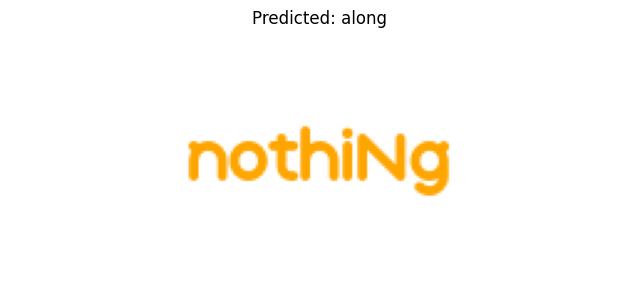

In [76]:
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
import os
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

WORD_LIST = ['community', 'already', 'leave', 'husband', 'glass', 'decide', 'class', 'today', 'certainly', 'record', 'animal', 'amount', 'charge', 'front', 'health', 'strategy', 'always', 'until', 'federal', 'world', 'recent', 'garden', 'second', 'level', 'across', 'disease', 'wonder', 'official', 'weapon', 'director', 'former', 'occur', 'worry', 'character', 'power', 'choose', 'perform', 'order', 'itself', 'artist', 'shake', 'those', 'could', 'positive', 'capital', 'material', 'person', 'expect', 'bring', 'attack', 'group', 'management', 'career', 'whose', 'claim', 'understand', 'violence', 'series', 'physical', 'drive', 'point', 'patient', 'floor', 'language', 'budget', 'either', 'writer', 'during', 'short', 'possible', 'laugh', 'future', 'natural', 'before', 'growth', 'woman', 'morning', 'prove', 'large', 'black', 'follow', 'month', 'force', 'statement', 'professor', 'several', 'democrat', 'kitchen', 'would', 'image', 'issue', 'remain', 'property', 'total', 'teach', 'decade', 'staff', 'whether', 'position', 'along']
WORD_LIST.sort()

model = CNN(num_classes=100)
checkpoint_path = "models/classification_accurate_100Epoch.pth"
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

hard_folder = "dataset/hard/"

random_image_path = hard_folder + random.choice(os.listdir(hard_folder))
print("Random image selected:", random_image_path)

# Read the image using matplotlib (or use PIL directly)
image_array = plt.imread(random_image_path)

# Convert NumPy array to PIL image (if necessary)
if image_array.dtype != 'uint8':
    image = Image.fromarray((image_array * 255).astype('uint8'))
else:
    image = Image.fromarray(image_array)

# Define the transformation pipeline
transform = transforms.Compose([
    transforms.Resize((100, 250)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


image_tensor = transform(image).to(device)
image_tensor = image_tensor.unsqueeze(0)


with torch.no_grad():
    output = model(image_tensor)
    _, predicted_class = torch.max(output, 1)
    prediction = WORD_LIST[predicted_class.item()]
    print("Predicted class:", prediction)
    confidence = torch.softmax(output, dim=1)[0][predicted_class].item() * 100
    print(f"Confidence: {confidence:.2f}%")


plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.title(f"Predicted: {prediction}")
plt.axis('off')
plt.show()

Random image selected: dataset/hard/single_0_Lobster_20_large.png
Predicted class: language
Confidence: 78.61%


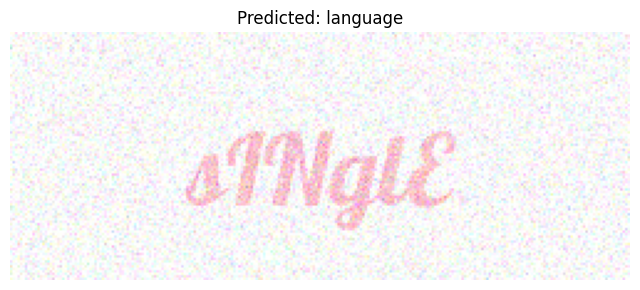

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
import os
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

WORD_LIST = ['community', 'already', 'leave', 'husband', 'glass', 'decide', 'class', 'today', 'certainly', 'record', 'animal', 'amount', 'charge', 'front', 'health', 'strategy', 'always', 'until', 'federal', 'world', 'recent', 'garden', 'second', 'level', 'across', 'disease', 'wonder', 'official', 'weapon', 'director', 'former', 'occur', 'worry', 'character', 'power', 'choose', 'perform', 'order', 'itself', 'artist', 'shake', 'those', 'could', 'positive', 'capital', 'material', 'person', 'expect', 'bring', 'attack', 'group', 'management', 'career', 'whose', 'claim', 'understand', 'violence', 'series', 'physical', 'drive', 'point', 'patient', 'floor', 'language', 'budget', 'either', 'writer', 'during', 'short', 'possible', 'laugh', 'future', 'natural', 'before', 'growth', 'woman', 'morning', 'prove', 'large', 'black', 'follow', 'month', 'force', 'statement', 'professor', 'several', 'democrat', 'kitchen', 'would', 'image', 'issue', 'remain', 'property', 'total', 'teach', 'decade', 'staff', 'whether', 'position', 'along']
WORD_LIST.sort()

model = CNN(num_classes=100)
checkpoint_path = "models/classification_accurate_100Epoch.pth"
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

hard_folder = "dataset/hard/"

random_image_path = hard_folder + random.choice(os.listdir(hard_folder))
print("Random image selected:", random_image_path)

# Read the image using matplotlib (or use PIL directly)
image_array = plt.imread(random_image_path)

# Convert NumPy array to PIL image (if necessary)
if image_array.dtype != 'uint8':
    image = Image.fromarray((image_array * 255).astype('uint8'))
else:
    image = Image.fromarray(image_array)

# Define the transformation pipeline
transform = transforms.Compose([
    transforms.Resize((100, 250)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


image_tensor = transform(image).to(device)
image_tensor = image_tensor.unsqueeze(0)


with torch.no_grad():
    output = model(image_tensor)
    _, predicted_class = torch.max(output, 1)
    prediction = WORD_LIST[predicted_class.item()]
    print("Predicted class:", prediction)
    confidence = torch.softmax(output, dim=1)[0][predicted_class].item() * 100
    print(f"Confidence: {confidence:.2f}%")


plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.title(f"Predicted: {prediction}")
plt.axis('off')
plt.show()

I came across this example after a few iterations of trying different images.

As you can see, the first letter and the last two letters have been identified correctly, and the `f` character somewhat looks like an r. However, this is only one good example, many others seem to make no sense.

I did the compute for this on a [kaggle notebook](https://www.kaggle.com/code/amolvijayachandran/task1-precog).